In [ ]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd


df = pd.read_csv("df_train.csv")
df = df.drop(df.columns[0], axis=1)
print(df)
train=df.sample(frac=0.8,random_state=20) #random state is a seed value
test=df.drop(train.index)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train_dataset = data.TensorDataset(torch.from_numpy(train[:,:-1]).float(),torch.from_numpy(train[:,-1]).float())
test_dataset = data.TensorDataset(torch.from_numpy(test[:,:-1]).float(),torch.from_numpy(test[:,-1]).float())
X_test = pd.read_csv("X_test.csv")
X_test_norm = scaler.transform(X_test.values)

X_test = X_test.drop(X_test.columns[0], axis=1)

train_data_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False)
x_test_data=data.TensorDataset(torch.from_numpy(X_test.values).float())

torch.cuda.is_available()
device = torch.device("cuda")
torch.cuda.empty_cache()

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      2.5847      17.0  5.764344   1.157787      1345.0  2.756148     33.78   
1      3.8792      22.0  4.715254   1.145763       810.0  2.745763     33.80   
2      1.5076      24.0  3.192563   1.087649      1566.0  2.079681     33.77   
3      6.7099      50.0  7.503521   1.035211       753.0  2.651408     34.11   
4      2.9286      20.0  2.337963   1.000000       326.0  1.509259     37.48   
...       ...       ...       ...        ...         ...       ...       ...   
14443  5.2882      25.0  5.987198   1.039829      2568.0  3.652916     37.54   
14444  4.1607      52.0  4.683363   1.093023      1328.0  2.375671     37.80   
14445  3.1333      34.0  4.353741   0.911565       754.0  2.564626     37.75   
14446  2.2109      23.0  5.363128   1.268156      1161.0  3.243017     34.11   
14447  3.2969      37.0  5.030973   0.898230       672.0  2.973451     34.08   

       Longitude  MedHouseVal  
0      

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
class MyModel(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn1 = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, 10)
        self.act_fn2 = nn.Tanh()
        self.linear3 = nn.Linear(10,200)
        self.act_fn3 = nn.Tanh()
        self.linear4 = nn.Linear(200, 200)
        self.act_fn4 = nn.ReLU()
        self.linear5 = nn.Linear(200, num_outputs)


#         self.linear3 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        # x = x.float()
        x = self.linear1(x)
        x = self.act_fn1(x)
        x = self.linear2(x)
        x = self.act_fn2(x)
        x = self.linear3(x)
        x = self.act_fn3(x)
        x = self.linear4(x)
        x = self.act_fn4(x)
        x = self.linear5(x)

        # print(x)
        return x

loss_module = nn.MSELoss()
# loss_module = nn.CrossEntropyLoss()

model = MyModel(num_inputs=8, num_hidden=20, num_outputs=1)
model.to(device)
# print(model)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.001,nesterov=True, momentum=0.9, dampening=0)
lossList = []

model.train()
# Training loop
for epoch in range(600):
    # print(epoch)
    for data_inputs, data_labels in train_data_loader:
        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        # print("inputs",data_inputs)
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        # data_labels = data_labels.long()
        loss = loss_module(preds, data_labels)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
    # print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    lossList.append(loss.item())

In [ ]:
import numpy as np

def mae(y_true,y_pred):
    return np.absolute(np.subtract(y_true, y_pred)).mean()

model.eval() # Set model to eval mode

MaeList = []

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in test_data_loader:

        # Determine prediction of model on dev set
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        preds = model(data_inputs)
        # print(preds)
        preds = preds.squeeze(dim=1)
        # print(preds)

        # # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
        # true_preds += (preds == data_labels).sum()
        # num_preds += data_labels.shape[0]

        MaeList.append(mae(data_labels.cpu(), preds.cpu()))
print(MaeList)
MaeValue = sum(MaeList)/len(MaeList)
print(MaeValue)
# acc = true_preds / num_preds
# print(f"Accuracy of the model: {100.0*acc:4.2f}%")

[tensor(0.2854), tensor(0.2866), tensor(0.3079), tensor(0.3018), tensor(0.3205), tensor(0.3236), tensor(0.3291), tensor(0.3083), tensor(0.2866), tensor(0.2457), tensor(0.3137), tensor(0.3497)]
tensor(0.3049)


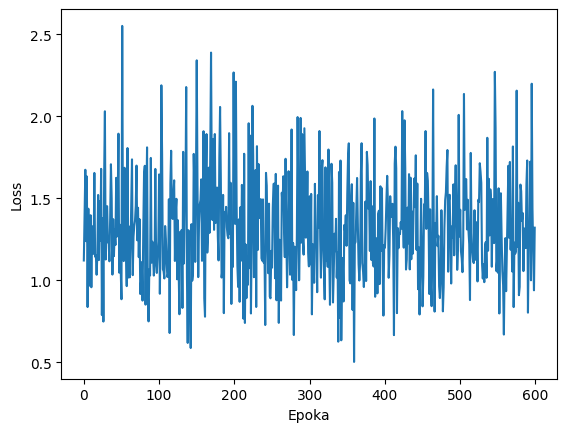

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lossList, "-")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.show()

In [ ]:
class MyModel(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, 50)
        self.act_fn1 = nn.Tanh()
        self.linear2 = nn.Linear(50, 30)
        self.act_fn2 = nn.Tanh()
        self.linear3 = nn.Linear(30,num_outputs)


#         self.linear3 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        # x = x.float()
        x = self.linear1(x)
        x = self.act_fn1(x)
        x = self.linear2(x)
        x = self.act_fn2(x)
        x = self.linear3(x)

        # print(x)
        return x

loss_module = nn.MSELoss()
# loss_module = nn.CrossEntropyLoss()

model = MyModel(num_inputs=8, num_hidden=20, num_outputs=1)
model.to(device)
# print(model)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
lossList = []

model.train()
# Training loop
for epoch in range(100):
    # print(epoch)
    for data_inputs, data_labels in train_data_loader:
        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        # print("inputs",data_inputs)
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        # data_labels = data_labels.long()
        loss = loss_module(preds, data_labels)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
    # print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    lossList.append(loss.item())

In [ ]:
all_preds = []
model.cpu()
with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs in x_test_data:

        # Determine prediction of model on dev set
        # print(data_inputs)
        preds = model(data_inputs[0])
        preds = preds.cpu().numpy()
        all_preds.append(preds)
all_preds = np.concatenate(all_preds, axis=0)
np.savetxt("predykcje.csv", all_preds, delimiter=",")